## Extraction

In [15]:
import os
import yaml
import pandas as pd
from pathlib import Path

# Define paths
data_root = r"D:\Data Science\Project 2 Stock Analysis\Data\data"
output_dir = r"D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV"
os.makedirs(output_dir, exist_ok=True)

# Go through each month folder (e.g., 2023-10, 2023-11, ...)
for month_folder in sorted(os.listdir(data_root)):
    month_path = os.path.join(data_root, month_folder)
    if not os.path.isdir(month_path):
        continue

    # Process each YAML file in that month
    for yaml_file in sorted(os.listdir(month_path)):
        if yaml_file.endswith('.yaml') or yaml_file.endswith('.yml'):
            file_path = os.path.join(month_path, yaml_file)

            with open(file_path, 'r') as f:
                daily_data = yaml.safe_load(f)

            # Get the date from the filename (e.g., 2023-10-03)
            date_str = Path(yaml_file).stem.split("_")[0]
            month_str = date_str[:7]  # Get 'YYYY-MM'

            # Convert the entire YAML data to CSV
            csv_file_path = os.path.join(output_dir, f"{date_str}.csv")

            # Check if the daily_data is a list or dictionary, then flatten it accordingly
            if isinstance(daily_data, list):
                # If the data is a list of dictionaries, we can convert it directly to a DataFrame
                df = pd.json_normalize(daily_data)
            else:
                # If the structure is more nested, we might need a different approach
                print(f"Warning: The YAML structure is not a list at {file_path}. Check the format.")
                continue

            # Add date and month as columns
            df['Date'] = date_str
            df['Month'] = month_str

            # Save the data to a CSV file
            df.to_csv(csv_file_path, index=False)

            print(f"Converted {yaml_file} to CSV at {csv_file_path}")

print("✅ All YAML files converted to CSV successfully.")


Converted 2023-10-03_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-03.csv
Converted 2023-10-04_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-04.csv
Converted 2023-10-05_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-05.csv
Converted 2023-10-06_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-06.csv
Converted 2023-10-09_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-09.csv
Converted 2023-10-10_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-10.csv
Converted 2023-10-11_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-11.csv
Converted 2023-10-12_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV\2023-10-12.csv
Converted 2023-10-13_05-30-00.yaml to CSV at D:\Data Science\Project 2 Stock Analysis\YAML_to_CS

In [21]:
import os
import pandas as pd

# Directory where the daily CSV files are located
input_dir = r"D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV"

# Initialize a dictionary to store the data for each company
company_data = {}

# Loop through each CSV file in the directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        # Read the CSV file for each day
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Extract the date from the file name (assuming the file name is in 'YYYY-MM-DD' format)
        date = file_name.split()[0]  # Extracting the date from the filename
        
        # Loop through each unique company (ticker) in the 'Ticker' column
        for company in df['Ticker'].unique():
            # Filter the data for the current company
            company_df = df[df['Ticker'] == company][['date', 'open', 'high', 'low', 'close', 'volume']]
            company_df['date'] = date  # Add the current date to the data
            
            # If this company is not already in the dictionary, initialize it with an empty list
            if company not in company_data:
                company_data[company] = []
            
            # Append the current day's data for this company
            company_data[company].append(company_df)

# Save each company's aggregated data into a separate CSV
for company, data in company_data.items():
    if data:  # Ensure there's data for the company
        # Concatenate data frames for the company into a single DataFrame
        company_df = pd.concat(data, ignore_index=True)
        
        # Save the data to a CSV file for that company
        company_df.to_csv(f"D:/Data Science/Project 2 Stock Analysis/{company}_Stock_Data.csv", index=False)



## ANALYSIS

In [22]:
import os
import pandas as pd

# Directory where the stock data CSV files are located
input_dir = r"D:/Data Science/Project 2 Stock Analysis"

# Initialize lists to store key metrics for each company
companies = []
yearly_returns = []
average_prices = []
average_volumes = []
green_stocks = 0
red_stocks = 0

# Loop through each CSV file in the directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('_Stock_Data.csv'):
        # Read the stock data CSV file for each company
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Get the company's ticker name from the file name (remove the "_Stock_Data.csv" part)
        company = file_name.replace('_Stock_Data.csv', '')
        companies.append(company)
        
        # Calculate yearly return (percentage change from the first open to the last close)
        first_open = df.iloc[0]['open']
        last_close = df.iloc[-1]['close']
        yearly_return = (last_close - first_open) / first_open * 100
        yearly_returns.append(yearly_return)
        
        # Calculate average price (mean of open, high, low, close)
        avg_price = df[['open', 'high', 'low', 'close']].mean().mean()
        average_prices.append(avg_price)
        
        # Calculate average volume
        avg_volume = df['volume'].mean()
        average_volumes.append(avg_volume)
        
        # Count green vs. red stocks (green if return > 0, red if return < 0)
        if yearly_return > 0:
            green_stocks += 1
        else:
            red_stocks += 1

# Create a DataFrame for all the key metrics
market_data = pd.DataFrame({
    'Company': companies,
    'Yearly Return (%)': yearly_returns,
    'Average Price': average_prices,
    'Average Volume': average_volumes
})

# Sort by Yearly Return to get top 10 green (positive return) and bottom 10 red (negative return) stocks
top_10_green = market_data.sort_values(by='Yearly Return (%)', ascending=False).head(10)
top_10_loss = market_data.sort_values(by='Yearly Return (%)', ascending=True).head(10)

# Market Summary Calculations
market_summary = {
    'Number of Green Stocks': green_stocks,
    'Number of Red Stocks': red_stocks,
    'Average Price Across All Stocks': market_data['Average Price'].mean(),
    'Average Volume Across All Stocks': market_data['Average Volume'].mean()
}

# Print the results
print("Top 10 Green Stocks:")
print(top_10_green[['Company', 'Yearly Return (%)']])
print("\nTop 10 Loss Stocks:")
print(top_10_loss[['Company', 'Yearly Return (%)']])
print("\nMarket Summary:")
print(market_summary)


Top 10 Green Stocks:
       Company  Yearly Return (%)
47       TRENT         220.725064
8          BEL         103.662074
30         M&M          88.639494
5   BAJAJ-AUTO          87.199408
9   BHARTIARTL          70.901171
35   POWERGRID          69.534591
10        BPCL          64.045911
20  HEROMOTOCO          56.772400
40   SUNPHARMA          54.827304
17     HCLTECH          54.028398

Top 10 Loss Stocks:
       Company  Yearly Return (%)
24  INDUSINDBK         -30.293296
3   ASIANPAINT         -21.916553
7   BAJFINANCE         -14.096879
0     ADANIENT          -7.857734
22  HINDUNILVR          -1.797189
32   NESTLEIND          -0.150620
28   KOTAKBANK           1.817919
31      MARUTI           3.303516
6   BAJAJFINSV           4.613625
46       TITAN           5.078125

Market Summary:
{'Number of Green Stocks': 44, 'Number of Red Stocks': 6, 'Average Price Across All Stocks': 2449.8171392605636, 'Average Volume Across All Stocks': 6833474.6491549285}


## 1.Volatility Analysis 

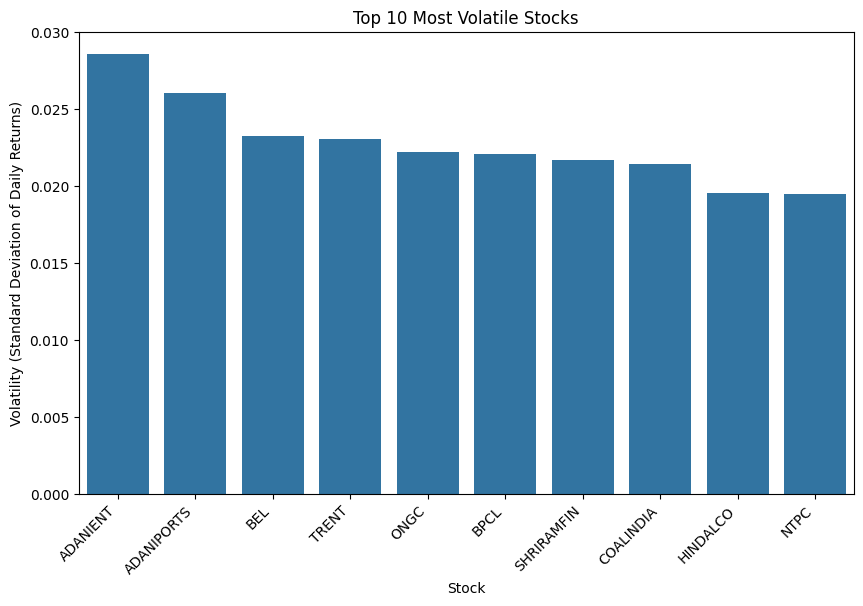

In [24]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory where the stock data CSV files are located
input_dir = r"D:/Data Science/Project 2 Stock Analysis"

# Initialize an empty dictionary to store the stock data for each company
company_data = {}

# Loop through each CSV file in the directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('_Stock_Data.csv'):
        # Read the stock data CSV file for each company
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Get the company's ticker name from the file name (remove the "_Stock_Data.csv" part)
        company = file_name.replace('_Stock_Data.csv', '')
        
        # Store the data for each company
        company_data[company] = df

# --- 1. Volatility Analysis ---
volatility = {}
for company, df in company_data.items():
    # Calculate daily returns (percentage change)
    df['daily_return'] = df['close'].pct_change()
    
    # Calculate the standard deviation of daily returns (volatility)
    volatility[company] = df['daily_return'].std()

# Sort companies by volatility and get the top 10 most volatile stocks
top_10_volatile = sorted(volatility.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_volatile_stocks = pd.DataFrame(top_10_volatile, columns=['Company', 'Volatility'])

# Plotting the volatility bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Company', y='Volatility', data=top_10_volatile_stocks)
plt.title('Top 10 Most Volatile Stocks')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Stock')
plt.ylabel('Volatility (Standard Deviation of Daily Returns)')
plt.show()


## 2. Cumulative Retrun Over Time

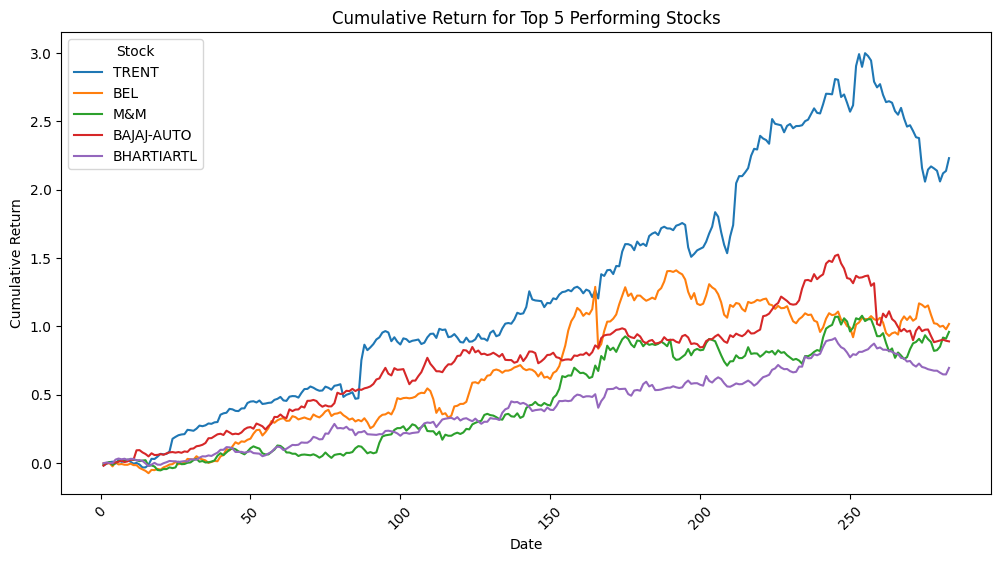

In [25]:
# --- 2. Cumulative Return Over Time ---
# Calculate cumulative return for each stock
cumulative_returns = {}
for company, df in company_data.items():
    # Calculate daily returns
    df['daily_return'] = df['close'].pct_change()
    
    # Calculate cumulative return
    df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
    cumulative_returns[company] = df[['date', 'cumulative_return']]

# Select the top 5 performing stocks based on cumulative return
top_5_performing = sorted(cumulative_returns.items(), key=lambda x: x[1].iloc[-1]['cumulative_return'], reverse=True)[:5]
top_5_cumulative = pd.DataFrame({company: data['cumulative_return'] for company, data in top_5_performing})

# Plotting the cumulative return for top 5 performing stocks
top_5_cumulative.plot(figsize=(12, 6), title='Cumulative Return for Top 5 Performing Stocks')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend(title='Stock')
plt.xticks(rotation=45)
plt.show()


## 3. Sector-wise Performance 


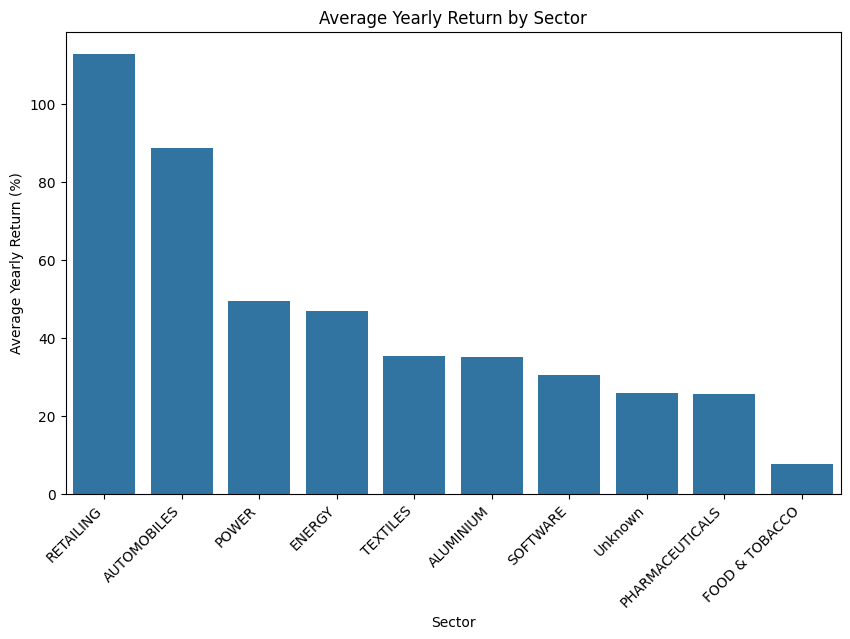

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a sector CSV file mapping each stock to a sector
sector_file = r"D:\Data Science\Project 2 Stock Analysis\Excel data\sector.csv"  # Replace with your actual path
sector_data = pd.read_csv(sector_file)

# Assuming company_data is a dictionary where each company's DataFrame is present
# Example:
# company_data = {'ADANI ENTERPRISES': df_adani, 'TATA STEEL': df_tata, ...}

# Calculate average yearly return for each sector
sector_returns = {}

for company, df in company_data.items():
    # Calculate yearly return (percentage change from the first open to the last close)
    first_open = df.iloc[0]['open']
    last_close = df.iloc[-1]['close']
    yearly_return = (last_close - first_open) / first_open * 100
    
    # Find sector of the company from sector_data
    sector_row = sector_data.loc[sector_data['COMPANY'] == company]
    
    if not sector_row.empty:
        sector = sector_row['sector'].values[0]  # Get the sector for the company
    else:
        # If the sector isn't found, you can skip or set to 'Unknown'
        sector = 'Unknown'

    # Add the return to the sector returns list
    if sector not in sector_returns:
        sector_returns[sector] = []
    sector_returns[sector].append(yearly_return)

# Calculate average yearly return for each sector
avg_sector_returns = {sector: np.mean(returns) for sector, returns in sector_returns.items()}

# Plotting the average yearly return by sector
sector_performance = pd.DataFrame(list(avg_sector_returns.items()), columns=['Sector', 'Average Yearly Return'])
sector_performance.sort_values(by='Average Yearly Return', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Sector', y='Average Yearly Return', data=sector_performance)
plt.title('Average Yearly Return by Sector')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Sector')
plt.ylabel('Average Yearly Return (%)')
plt.show()

df['']


## 4. Stock Price Correlation 


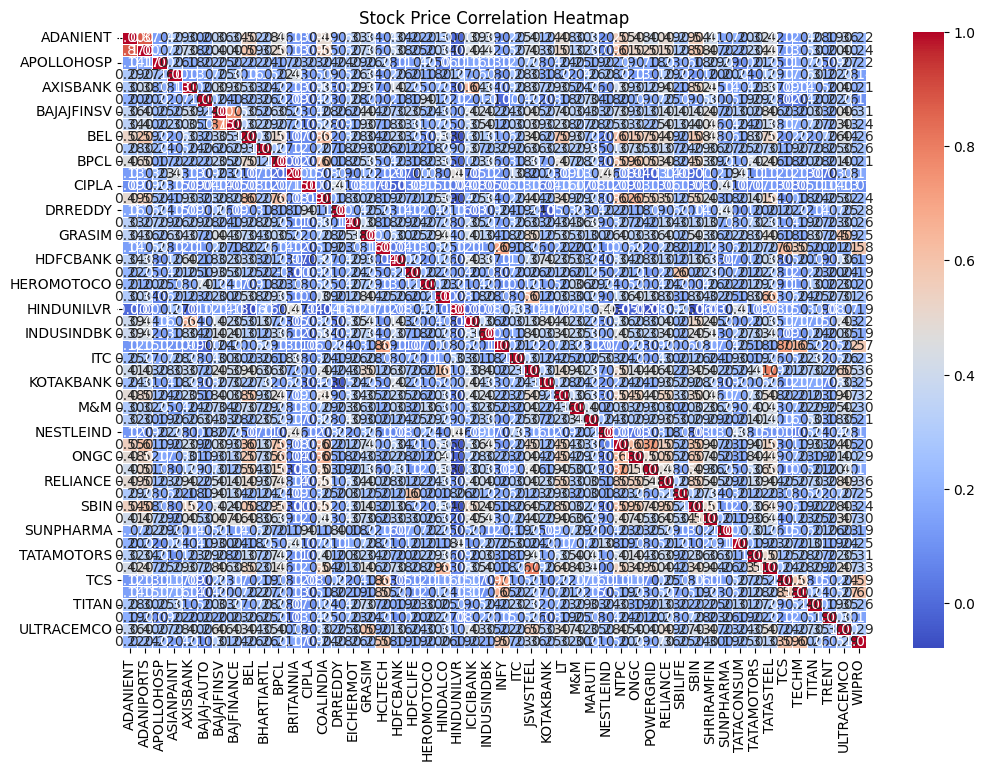

In [27]:
# Calculate correlation matrix for the stock prices
close_prices = pd.DataFrame({company: df['close'] for company, df in company_data.items()})
correlation_matrix = close_prices.pct_change().corr()

# Plotting the heatmap for stock price correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Stock Price Correlation Heatmap')
plt.show()


##  5. Top 5 Gainers and Losers (Month-wise) ---


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load all CSV files
folder_path = r'D:\Data Science\Project 2 Stock Analysis\YAML_to_CSV'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

combined_df = pd.DataFrame()

# Step 2: Concatenate all data into one DataFrame
for file in all_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Safe datetime parsing
    df.dropna(subset=['Date'], inplace=True)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Step 3: Add daily return
combined_df.sort_values(by=['Ticker', 'Date'], inplace=True)
combined_df['daily_return'] = combined_df.groupby('Ticker')['close'].pct_change()

# Step 4: Group by Ticker and Month
combined_df['Month'] = combined_df['Date'].dt.to_period('M').astype(str)
grouped = combined_df.groupby(['Month', 'Ticker'])

# Step 5: Calculate monthly start and end price and return
monthly_stats = grouped.agg({
    'close': ['first', 'last'],
    'daily_return': 'mean'
}).reset_index()

monthly_stats.columns = ['Month', 'Ticker', 'start_price', 'end_price', 'avg_daily_return']
monthly_stats['monthly_return'] = (monthly_stats['end_price'] - monthly_stats['start_price']) / monthly_stats['start_price']

# Step 6: Plot Top 5 Gainers and Losers for each month
output_dir = "monthly_gainers_losers_charts"
os.makedirs(output_dir, exist_ok=True)

unique_months = monthly_stats['Month'].unique()

for month in unique_months:
    month_data = monthly_stats[monthly_stats['Month'] == month].copy()

    # Top 5 Gainers
    top_gainers = month_data.sort_values(by='monthly_return', ascending=False).head(5)

    # Top 5 Losers
    top_losers = month_data.sort_values(by='monthly_return', ascending=True).head(5)

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Top 5 Gainers and Losers - {month}", fontsize=16, fontweight='bold')

    # Gainers plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='monthly_return', y='Ticker', data=top_gainers, palette='Greens_d')
    plt.title("Top 5 Gainers")
    plt.xlabel("Monthly Return")
    plt.ylabel("")

    # Losers plot
    plt.subplot(1, 2, 2)
    sns.barplot(x='monthly_return', y='Ticker', data=top_losers, palette='Reds_d')
    plt.title("Top 5 Losers")
    plt.xlabel("Monthly Return")
    plt.ylabel("")

    # Save plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{output_dir}/Top_5_Gainers_Losers_{month}.png")
    plt.close()

print(f"Charts saved in folder: {output_dir}")
